# PHYS3070: Negatively buoyant ball (Stokes Sinker)

Romain Beucher and Louis Moresi

Imagine a tank of thick, viscous fluid (like syrup, for example). This turns out to be a reasonable model for the
interior of a solid (rocky / icy) planet if we consider the evolution on a geological timescale. A cold / dense
blob of material sinks and stirs a tank of fluid just like this computer model shows.

## Import python tools

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


## Scaling

In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.hour
model_height = 1. * u.meter
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
temperature_diff = 500. * u.degK

characteristic_length = model_height
characteristic_time = characteristic_length / velocity
characteristic_mass = bodyforce * characteristic_length**2 * characteristic_time**2
characteristic_temperature = temperature_diff

GEO.scaling_coefficients["[length]"] = characteristic_length
GEO.scaling_coefficients["[time]"] = characteristic_time
GEO.scaling_coefficients["[mass]"]=characteristic_mass
GEO.scaling_coefficients["[temperature]"] = characteristic_temperature

# Geometry

We define a tank in 2-dimensions. The dimension of the tank is set to be 1m in height and 1m in width. The extent of the tank is defined using the `minCoord` and `maxCoord` arguments chosen in a way that the origin is located at the center of the tank. We define the number of elements used to discretise the domain.

In [4]:
Model = GEO.Model(elementRes=(64, 64), minCoord=(-0.5 * u.m, -0.5 * u.m), maxCoord=(0.5 * u.m, 0.5 * u.m))

## Materials

The tank is filled with a viscous fluid (`background_fluid`).
A ball of colder / denser material (`ball`) is placed in the fluid 30 cm above the center of the tank (20cm from the top of the box.). The ball diameter is chosen to be 20cm.

In [5]:
background_fluid = Model.add_material(name="Background", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))

Disk = GEO.shapes.Disk(center=(0.,30.*u.centimetre), radius=10 * u.centimetre)
ball = Model.add_material(name="Ball", shape=Disk)


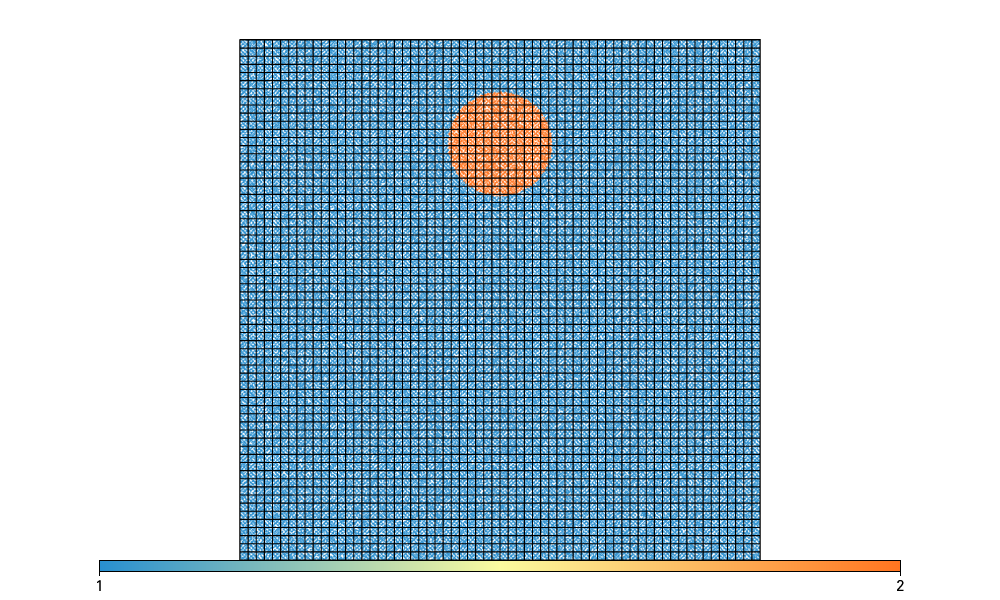

In [6]:
Fig = glucifer.Figure(figsize=(1000,600))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.show()

### Material properties

In [7]:
background_fluid.density = 10 * u.kilogram / u.metre**3
background_fluid.viscosity = 1e5 * u.pascal * u.second

ball.viscosity = 1e6 * u.pascal * u.second
ball.density = 500 * u.kilogram / u.metre**3

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



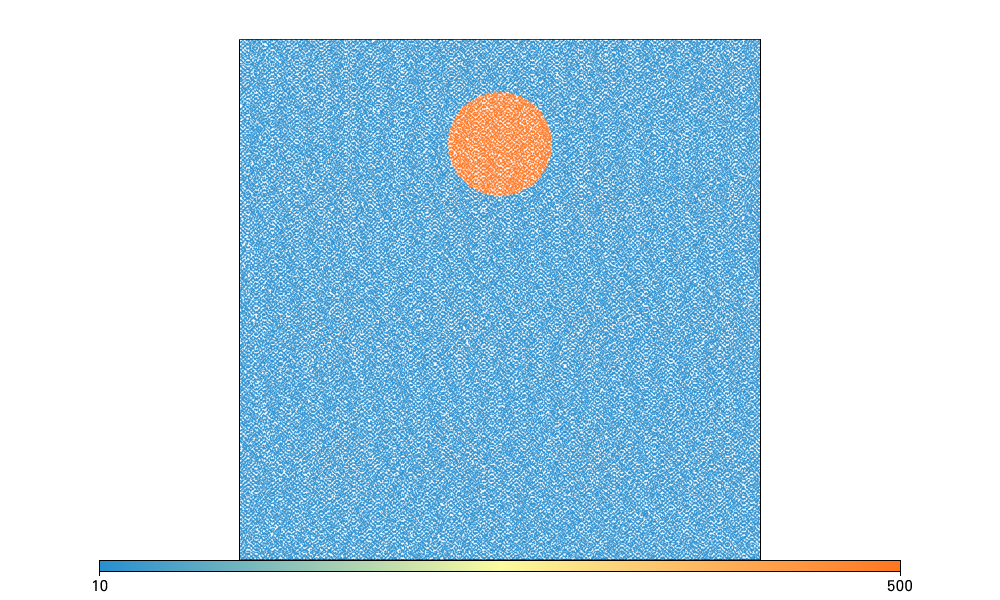

In [8]:
Fig = glucifer.Figure(figsize=(1000,600))
Fig.Points(Model.swarm, GEO.dimensionalise(Model.densityField, u.kg/u.m**3), fn_size=2.0, title="Density Field")
Fig.show()

## Define Boundary Conditions

The boundary conditions are freeslip everywhere (zero shear stress).

In [9]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])

## Passive Tracers

In [10]:
import numpy as np

angles = np.arange(0., 360)
x = 10. * u.cm * np.cos(np.radians(angles)) 
y = 10. * u.cm * np.sin(np.radians(angles)) + 30. * u.cm

ball_contour = Model.add_passive_tracers(name="ball_contour", vertices=[x, y])


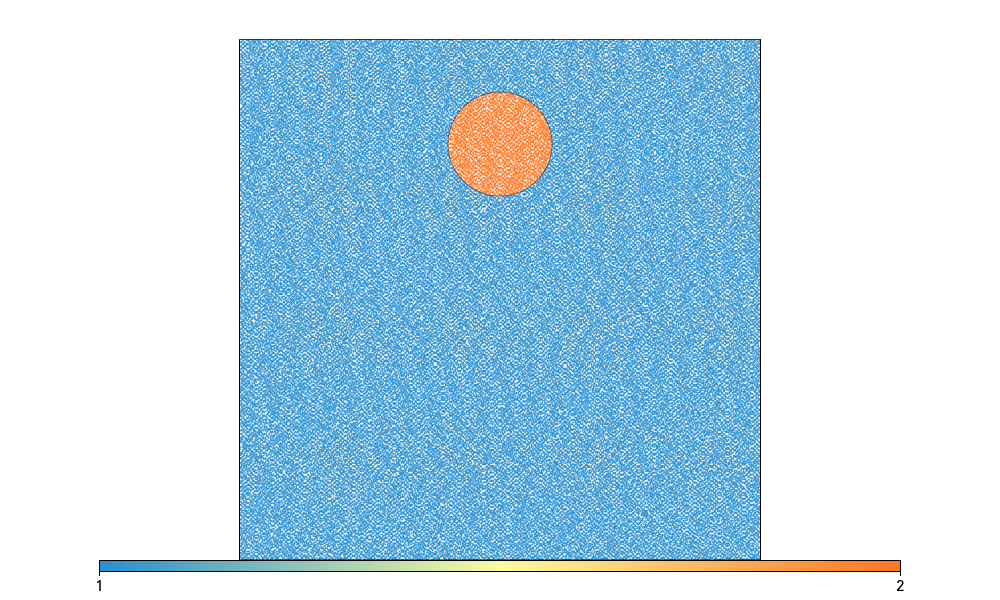

In [11]:
Fig = glucifer.Figure(figsize=(1000,600))
Fig.Points(ball_contour, size=10.0, colour="k")
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

In [12]:
Model.init_model()

In [13]:
Model.run_for(nstep=100, checkpoint_interval=1)

Running with UWGeodynamics version 2.8.1-dev-d0ac155(master)
Options:  -restore_K False -rescale_equations False -remove_constant_pressure_null_space False -Q22_pc_type uw -ksp_type bsscr -change_A11rhspresolve False -ksp_k2_type NULL -change_backsolve False -pc_type none -A11_ksp_rtol 1e-06 -A11_ksp_type fgmres -scr_ksp_rtol 1e-05 -scr_ksp_type fgmres
Step:     1 Model Time: 1.5 minute dt: 1.5 minute (2019-09-23 03:29:11)
Step:     2 Model Time: 2.9 minute dt: 1.4 minute (2019-09-23 03:29:13)
Step:     3 Model Time: 4.3 minute dt: 1.4 minute (2019-09-23 03:29:16)
Step:     4 Model Time: 5.6 minute dt: 1.3 minute (2019-09-23 03:29:19)
Step:     5 Model Time: 6.9 minute dt: 1.3 minute (2019-09-23 03:29:22)
Step:     6 Model Time: 8.2 minute dt: 1.3 minute (2019-09-23 03:29:25)
Step:     7 Model Time: 9.5 minute dt: 1.3 minute (2019-09-23 03:29:28)
Step:     8 Model Time: 10.7 minute dt: 1.2 minute (2019-09-23 03:29:31)
Step:     9 Model Time: 12.0 minute dt: 1.2 minute (2019-09-23 03:29

1


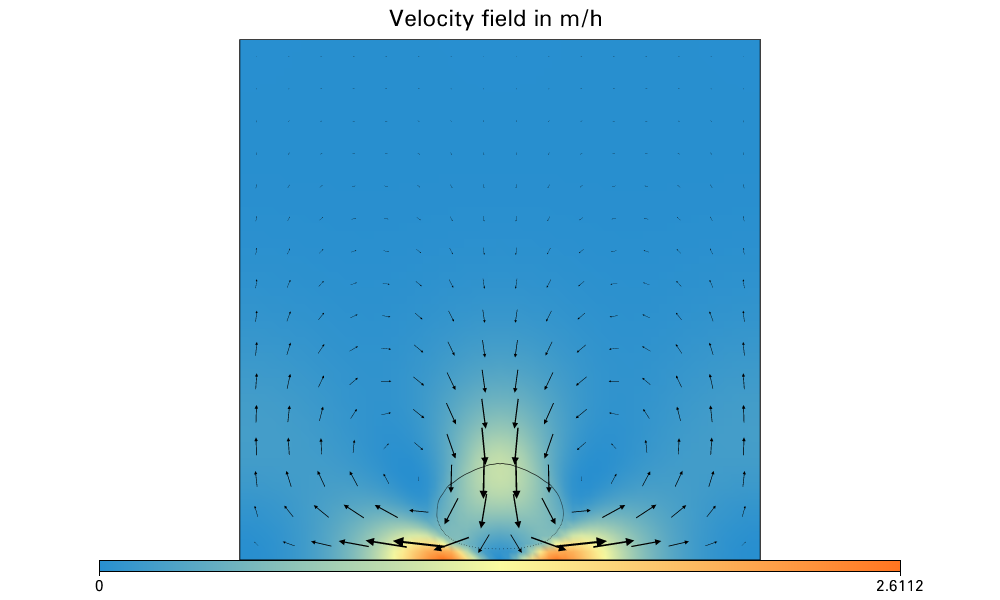

In [14]:
import underworld.function as fn
# Calculate the velocity magnitude
velocityMag = fn.math.dot(Model.velocityField, Model.velocityField)
# Get a conversion factor to units of m/hr
fact = GEO.dimensionalise(1.0, u.metre / u.hour).magnitude
# Apply the factor to the velocity Magnitude
velocityMag *= fact

Fig = glucifer.Figure(figsize=(1000,600), title="Velocity field in m/h")
Fig.Points(ball_contour, colour="k")
Fig.Surface(Model.mesh, velocityMag)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()